<a href="https://colab.research.google.com/github/arvindcsekar/GW-PTA-PINN/blob/main/PINN_GW_multiparam_pulsar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch    0 | Total: 3.602704e-22 | BC: 0.000000e+00 | Residual: 3.602704e-30
Epoch  100 | Total: 3.625684e-22 | BC: 0.000000e+00 | Residual: 3.625684e-30
Epoch  200 | Total: 3.638320e-22 | BC: 0.000000e+00 | Residual: 3.638320e-30
Epoch  300 | Total: 3.653529e-22 | BC: 0.000000e+00 | Residual: 3.653529e-30
Epoch  400 | Total: 3.603408e-22 | BC: 0.000000e+00 | Residual: 3.603408e-30
Epoch  500 | Total: 3.652757e-22 | BC: 0.000000e+00 | Residual: 3.652757e-30
Epoch  600 | Total: 3.633492e-22 | BC: 0.000000e+00 | Residual: 3.633492e-30
Epoch  700 | Total: 3.623846e-22 | BC: 0.000000e+00 | Residual: 3.623846e-30
Epoch  800 | Total: 3.600805e-22 | BC: 0.000000e+00 | Residual: 3.600805e-30
Epoch  900 | Total: 3.612640e-22 | BC: 0.000000e+00 | Residual: 3.612640e-30


/tmp/ipython-input-2875319134.py:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_earth_norm = torch.tensor(t_earth_norm, dtype=torch.float64).view(-1, 1)
/tmp/ipython-input-2875319134.py:156: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_pulsar_norm = torch.tensor(t_pulsar_norm, dtype=torch.float64).view(-1, 1)


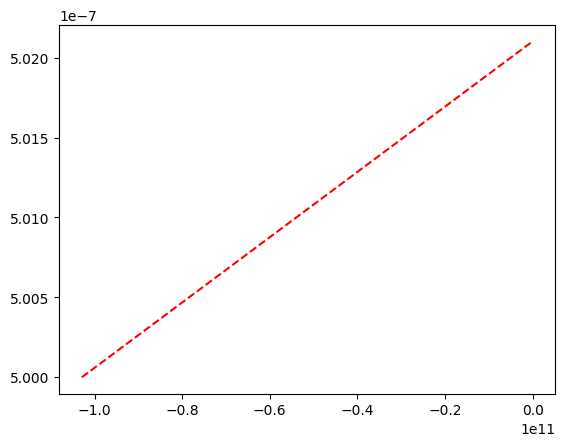

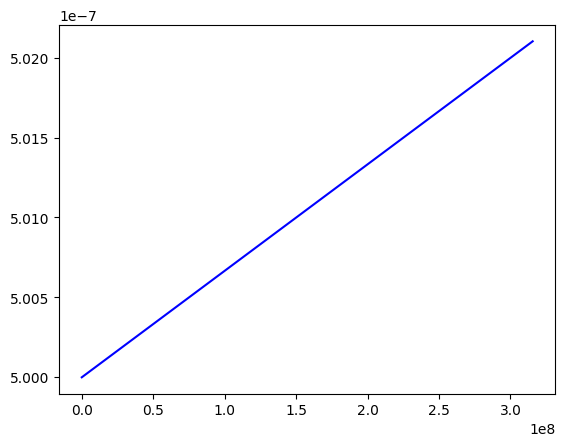

[5.e-07]
[1.18157981e-06]


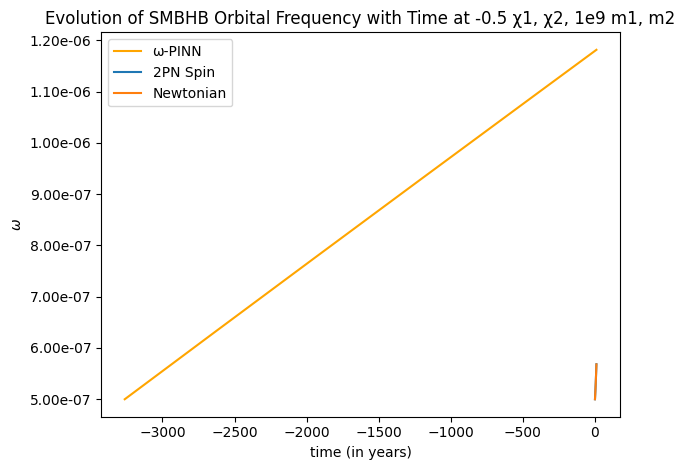

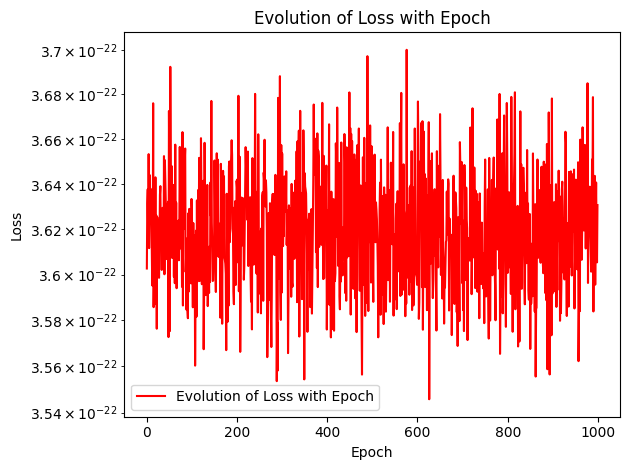

[φ] Epoch 0 | Total 4.105e+31 | BC 4.105e+20 | Resid 1.803e-04
[φ] Epoch 100 | Total 1.111e+29 | BC 1.111e+18 | Resid 2.224e-04
[φ] Epoch 200 | Total 9.083e+27 | BC 9.083e+16 | Resid 3.752e-05
[φ] Epoch 300 | Total 1.640e+28 | BC 1.640e+17 | Resid 3.260e-05
[φ] Epoch 400 | Total 7.154e+27 | BC 7.154e+16 | Resid 4.812e-05
[φ] Epoch 500 | Total 1.567e+26 | BC 1.567e+15 | Resid 4.880e-05
[φ] Epoch 600 | Total 9.259e+27 | BC 9.259e+16 | Resid 4.301e-05
[φ] Epoch 700 | Total 3.684e+27 | BC 3.684e+16 | Resid 1.519e-05
[φ] Epoch 800 | Total 1.262e+26 | BC 1.262e+15 | Resid 2.315e-05
[φ] Epoch 900 | Total 3.339e+27 | BC 3.339e+16 | Resid 2.219e-05


/tmp/ipython-input-2875319134.py:337: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_earth_norm = torch.tensor(t_earth_norm, dtype=torch.float64).view(-1, 1)
/tmp/ipython-input-2875319134.py:338: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_pulsar_norm = torch.tensor(t_pulsar_norm, dtype=torch.float64).view(-1, 1)


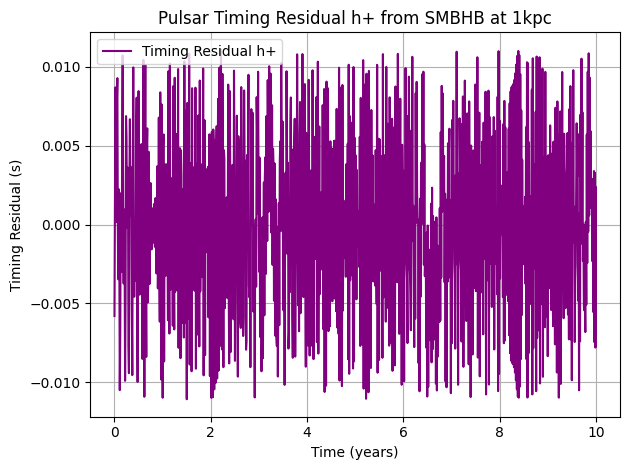

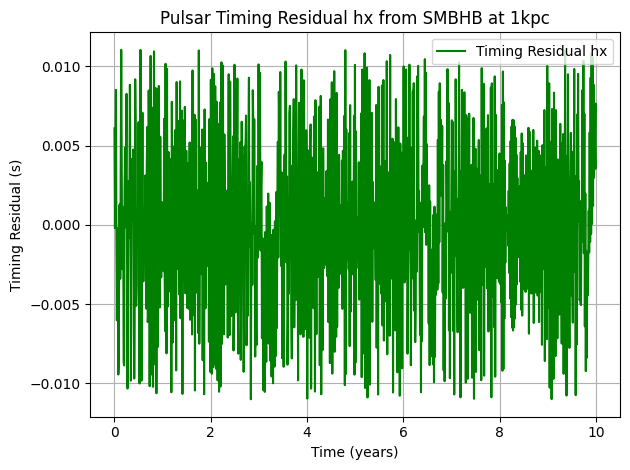

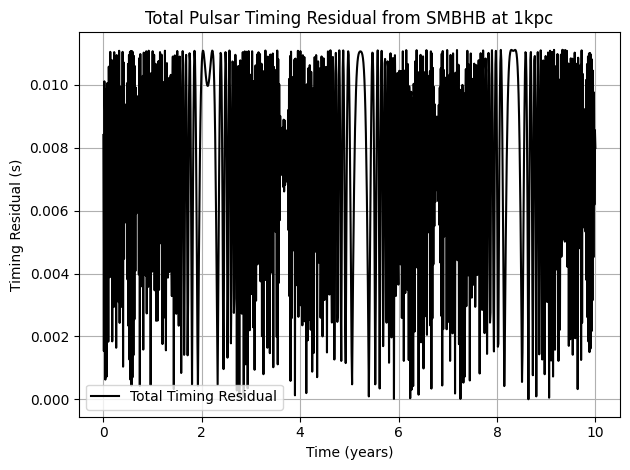

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import torch
import torch.nn as nn
import torch.optim as optim
from astropy import units as u
from astropy import constants as ac

torch.manual_seed(42)
np.random.seed(42)

G_SI = ac.G.value #m^3 kg^-1 s^-2
c_SI = ac.c.value #m s^-1
M_sun_SI = ac.M_sun.value #kg

G = torch.tensor(G_SI, dtype=torch.float64)
c = torch.tensor(c_SI, dtype=torch.float64)

#pulsar delay time at 1kpc
L = 1000 * ac.pc.value
delta_t = L/ac.c.value
t_start_new = -(delta_t)
t_snew = torch.tensor(t_start_new, dtype=torch.float64)
t_end = (10 * u.yr).to(u.s).value
t_end_torch = torch.tensor(t_end, dtype=torch.float64)
t_range = torch.tensor(t_end - t_start_new, dtype=torch.float64)


#normalisation: scale masses by 1e9 Msun
M_scale = 1e9 * M_sun_SI

class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(5, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1, bias=True)
        )
        self.register_buffer('omega0', torch.tensor(5e-7, dtype=torch.float64))  #baseline near BC
        self.register_buffer('scale',  torch.tensor(1e-6, dtype=torch.float64))
        self.double()

    def forward(self, x):
      z = self.net(x)  # unconstrained
      f = torch.nn.functional.softplus(z) * self.scale  # positive variation
      t_norm = x[:, 0:1]  # normalized time [0,1]
      omega = self.omega0 + t_norm * f  # omega scaled to time norm
      return omega


def compute_residual_loss(model, num_points):
    t_norm = torch.rand(num_points, 1, dtype=torch.float64)
    t_phys = t_start_new + t_norm * t_range
    #need to hard code chi and masses here so network learns exact solution
    chi_1_res = torch.full((num_points, 1), -0.5, dtype=torch.float64)
    chi_2_res = torch.full((num_points, 1), -0.5, dtype=torch.float64)


    m1_phys = torch.full((num_points, 1), 1e9 * M_sun_SI, dtype=torch.float64)
    m2_phys = torch.full((num_points, 1), 1e9 * M_sun_SI, dtype=torch.float64)


    m1_norm = m1_phys / M_scale
    m2_norm = m2_phys / M_scale

    batch_inputs = torch.cat([t_norm, chi_1_res, chi_2_res, m1_norm, m2_norm], dim=1).requires_grad_()

    chi_A = 0.5 * (chi_1_res - chi_2_res)
    chi_S = 0.5 * (chi_1_res + chi_2_res)

    m_total = m1_phys + m2_phys
    eta = (m1_phys * m2_phys) / (m_total**2)
    m_chirp = (eta ** (3.0/5.0)) * m_total

    omega = model(batch_inputs)
    delta = torch.sqrt(torch.clamp(1.0 - 4.0 * eta, min=0.0))
    Q_15 = (-113.0/12.0) * chi_A * delta + (19.0/3.0) * chi_S * eta - (113.0/12.0) * chi_S + 4.0 * torch.pi

    tN_omg = (G * m_chirp * omega) / (c**3)  #dimensionless
    tm_omg = (G * m_total * omega) / (c**3)  #dimensionless

    RHS_t = (96.0/5.0) * (
        1.0
        + ( (59.0/18.0) * (eta**2) + (13661.0/2016.0) * eta + (34103.0/18144.0) ) * (tm_omg ** (4.0/3.0))
        + tm_omg * (Q_15)
        + ( -11.0/4.0 * eta - 743.0/336.0 ) * (tm_omg ** (2.0/3.0))
    ) * (omega**2) * (tN_omg ** (5.0/3.0))

    grads = torch.autograd.grad(
        outputs=omega,
        inputs=batch_inputs,
        grad_outputs=torch.ones_like(omega),
        create_graph=True,
    )[0]
    domega_dtau = grads[:, 0:1]  #derivative wrt t (first column)

    domega_dt_phys = domega_dtau / t_range
    residual = domega_dt_phys - RHS_t
    residual_loss = torch.mean(residual**2)
    return residual_loss

num_points = 30000
epoch_num = 1000

model = PINN()
optimiser = optim.Adam(model.parameters(), lr=1.7e-4)
loss_MSE = nn.MSELoss()

loss_arr = []

for epoch in range(epoch_num):
    optimiser.zero_grad()

    t_bc = torch.tensor([[0.0]], dtype=torch.float64)
    chi0 = torch.full_like(t_bc, -0.5)
    m0_norm = torch.ones_like(t_bc)

    bc_inputs = torch.cat([t_bc, chi0, chi0, m0_norm, m0_norm], dim=1)
    omg_pred_bc = model(bc_inputs)
    omg_target_bc = torch.tensor([[5e-7]], dtype=torch.float64)
    bc_loss = loss_MSE(omg_pred_bc, omg_target_bc)

    residual_loss = compute_residual_loss(model, num_points)
    w1 = 1
    w2 = 1e8

    total_loss = w1 * bc_loss + w2 * residual_loss
    total_loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.2) #adjust norm
    optimiser.step()

    loss_arr.append(total_loss.item())

    if epoch % 100 == 0:
        print(f"Epoch {epoch:4d} | Total: {total_loss.item():.6e} | BC: {bc_loss.item():.6e} | Residual: {residual_loss.item():.6e}")

t_values = np.linspace(0.0, 1.0, 1000)
t_norm_infer = torch.linspace(0.0, 1.0, 1000).view(-1, 1)
t_phys_infer = t_start_new + t_norm_infer * t_range

t_earth_phys = np.linspace(0.0, t_end, 1000)
t_pulsar_phys = t_earth_phys - delta_t
t_earth_norm = t_earth_phys / t_range
t_pulsar_norm = (t_pulsar_phys - t_start_new) / t_range
t_earth_norm = torch.tensor(t_earth_norm, dtype=torch.float64).view(-1, 1)
t_earth_years = t_earth_phys * u.yr.to(u.s)
t_pulsar_specific_years = np.linspace(-(delta_t), 0, 1000)
t_pulsar_norm = torch.tensor(t_pulsar_norm, dtype=torch.float64).view(-1, 1)
t_years = (t_phys_infer.detach().numpy()) / u.yr.to(u.s)

#t_earth and t_pulsar norm have same shape so it doesn't matter
sample_chi1 = torch.full_like(t_earth_norm, -0.5)
sample_chi2 = torch.full_like(t_earth_norm, -0.5)
sample_m1_norm = torch.ones_like(t_earth_norm)
sample_m2_norm = torch.ones_like(t_earth_norm)

#inputs with both time intervals
earth_inputs = torch.cat([t_earth_norm, sample_chi1, sample_chi2, sample_m1_norm, sample_m2_norm], dim=1)
pulsar_inputs = torch.cat([t_pulsar_norm, sample_chi1, sample_chi2, sample_m1_norm, sample_m2_norm], dim=1)

#omega evaluated at both intervals
omega_tensor_earth = model(earth_inputs)
omega_tensor_pulsar = model(pulsar_inputs)

plt.plot(t_pulsar_specific_years, omega_tensor_pulsar.detach().numpy(), label="Pulsar", color="red", linestyle="--")
plt.show()
plt.plot(t_earth_phys, omega_tensor_earth.detach().numpy(), label="Earth", color="blue", linestyle="-")
plt.show()

#need special BC for pulsar?

sample_chi1_infer = torch.full_like(t_norm_infer, -0.5)
sample_chi2_infer = torch.full_like(t_norm_infer, -0.5)
sample_m1_norm_infer = torch.ones_like(t_norm_infer)
sample_m2_norm_infer = torch.ones_like(t_norm_infer)

infer_inputs = torch.cat([t_norm_infer, sample_chi1_infer, sample_chi2_infer, sample_m1_norm_infer, sample_m2_norm_infer], dim=1).to(torch.float64)
omega_tensor = model(infer_inputs)
omega_np = omega_tensor.detach().numpy()

t_years = (t_phys_infer.detach().numpy()) / u.yr.to(u.s)

print(omega_np[0])
print(omega_np[-1])

plt.figure()
plt.plot(t_years, omega_np, label="Predicted Evolution of SMBHB Orbital Frequency with Time", color="orange")
plt.title("Evolution of SMBHB Orbital Frequency with Time")
plt.xlabel('Time (years)')
plt.ylabel('Orbital Frequency ω (rad/s)')
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2e'))
plt.legend()
plt.tight_layout()

GMsun = ac.GM_sun.value
c = ac.c.value
dsun = GMsun/(c**2)
tsun = GMsun/(c**3)
pc = ac.pc.value
yr = (365.25)*(24)*(60)*(60)

def get_omg(t,t_a,omg_a,m_c,eta,nu,chi_A,chi_S):
    m=m_c/eta**(3/5)
    tN_ = m_c*omg_a*tsun
    tm_ = m*omg_a*tsun
    tmta_ = t-t_a
    delta=np.sqrt(1-4*eta)
    tau = 1-256/5*omg_a*tN_**(5/3)*tmta_
    Q15=(-113/12*chi_A*delta+19/3*chi_S*eta-113/12*chi_S+4*np.pi)
    ww=(omg_a*(((371/128*eta**2+56975/16128*eta+1855099/903168)/tau**(7/8)+(-3058673/
    1354752-617/192*eta**2-5429/1344*eta)/tau**(11/8)+(-605/192*eta**2-40865/8064*eta-\
    2760245/1354752)/tau**(13/8)+(1331/384*eta**2+89903/16128*eta+6072539/2709504)/
    tau**(19/8))*tm_**(4/3)*nu**2+(3/5/tau**(11/8)*Q15-3/5/tau**(3/4)*Q15)*tm_*nu**(3/2)+
    ((11/8*eta+743/672)/tau**(5/8)+(-11/8*eta-743/672)/tau**(11/8))*tm_**(2/3)*nu+1/
    tau**(3/8)))
    return ww

t=np.linspace(0,10,100)*yr
t_a=0
omg_a= 5e-7
m_c=(1e9**2)**(3/5) / (2*1e9)**(1/5)
eta=1/4
nu=1
chi1 = -0.5
chi2 = -0.5
chi_A = 0.5*(chi1-chi2)
chi_S = 0.5*(chi1+chi2)
#chi_A ranges from (-0.5,0.5)
#chi_S ranges from (0,1)

omg_arr=get_omg(t,t_a,omg_a,m_c,eta,nu,chi_A,chi_S)
omg_arr_Q=get_omg(t,t_a,omg_a,m_c,eta,0,chi_A,chi_S)

plt.plot(t/yr,omg_arr)
plt.plot(t/yr,omg_arr_Q)
plt.legend(["ω-PINN", "2PN Spin", "Newtonian"])
plt.title("Evolution of SMBHB Orbital Frequency with Time at -0.5 χ1, χ2, 1e9 m1, m2")
plt.xlabel("time (in years)")
plt.ylabel(r"$\omega$")
plt.show()

plt.figure()
plt.plot(range(epoch_num), loss_arr, label="Evolution of Loss with Epoch", color="red")
plt.title("Evolution of Loss with Epoch")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.tight_layout()

plt.show()

class PINN2(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )
        self.double()

    def forward(self, t):
        return self.net(t) * t_range    # <-- FIX: remove exp, scale by t_range so dφ/dt_phys has correct scale

def compute_residual_loss_phi(model2, t_batch, model):
    t_pred = t_batch.requires_grad_()
    phi_pred = model2(t_pred)
    dphi_dt = torch.autograd.grad(phi_pred, t_pred, grad_outputs=torch.ones_like(phi_pred), create_graph=True)[0]

    chi1 = torch.full_like(t_pred, -0.5)   # <-- FIX: use same chi = -0.5 here
    chi2 = torch.full_like(t_pred, -0.5)
    m1_norm = torch.ones_like(t_pred)
    m2_norm = torch.ones_like(t_pred)

    t_phys_pred = t_start_new + t_pred * t_range
    omega_here = model(torch.cat([t_pred, chi1, chi2, m1_norm, m2_norm], dim=1))


    dphi_dt_phys = dphi_dt / t_range
    residual = dphi_dt_phys - omega_here
    return torch.mean(residual**2)


phi_enforced = torch.tensor([[0.0]], dtype=torch.float64)
dphi_dt_enforced = model(torch.cat([torch.tensor([[0.0]], dtype=torch.float64), sample_chi1_infer[:1], sample_chi2_infer[:1], sample_m1_norm_infer[:1], sample_m2_norm_infer[:1]], dim=1))
model2 = PINN2()
opt_phi = optim.Adam(model2.parameters(), lr=1e-3)
loss_arr_phi = []
w1_phi = 1e11
w2_phi = 1e7

t_pool = torch.linspace(0.0, 1.0, steps=num_points, dtype=torch.float64).view(-1, 1)
t_phys_phi = t_start_new + t_pool * t_range

for epoch in range(epoch_num):
    opt_phi.zero_grad()

    bc_inputs2 = torch.tensor([[0.0]], dtype=torch.float64)
    phi_pred_bc = model2(bc_inputs2)
    bc_loss_phi = loss_MSE(phi_pred_bc, phi_enforced)

    idx = torch.randperm(num_points)[:1024]
    t_batch = t_pool[idx]
    residual_loss_phi = compute_residual_loss_phi(model2, t_batch, model)

    total_loss_phi = w1_phi * bc_loss_phi + w2_phi * residual_loss_phi
    total_loss_phi.backward()
    torch.nn.utils.clip_grad_norm_(model2.parameters(), 1.0)
    opt_phi.step()

    loss_arr_phi.append(total_loss_phi.item())
    if epoch % 100 == 0:
        print(f"[φ] Epoch {epoch} | Total {total_loss_phi.item():.3e} | BC {bc_loss_phi.item():.3e} | Resid {residual_loss_phi.item():.3e}")

t_vals = torch.linspace(0.0, 1.0, 1000, dtype=torch.float64).view(-1,1)
t_phys = t_start_new + t_vals * t_range
phi_pred = model2(t_vals).detach().numpy()
t_years_phi = (t_phys / u.yr.to(u.s)).detach().numpy()

t_earth_phys = np.linspace(0.0, t_end, 1000)
t_pulsar_phys = t_earth_phys - delta_t
t_earth_norm = (t_earth_phys - t_start_new) / t_range
t_pulsar_norm = (t_pulsar_phys - t_start_new) / t_range
t_earth_norm = torch.tensor(t_earth_norm, dtype=torch.float64).view(-1, 1)
t_pulsar_norm = torch.tensor(t_pulsar_norm, dtype=torch.float64).view(-1, 1)

phi_earth = model2(t_earth_norm)
phi_pulsar = model2(t_pulsar_norm)

m1_kg = 1e9 * M_sun_SI  # mass in kg (assuming your m1 = 1e9 Msun)
m2_kg = 1e9 * M_sun_SI

chirp_mass_kg = (m1_kg * m2_kg)**(3/5) / (m1_kg + m2_kg)**(1/5)

# Calculate dimensionless frequency scale for normalization
omega_scale = (c_SI**3) / (G_SI * chirp_mass_kg)

# Normalize omega tensors to dimensionless units
omega_earth_dimless = omega_tensor_earth / omega_scale
omega_pulsar_dimless = omega_tensor_pulsar / omega_scale

# Compute strain h+ (plus polarization) at Earth and pulsar times
h_plus_earth = omega_earth_dimless**(2/3) * torch.cos(2 * phi_earth)
h_plus_pulsar = omega_pulsar_dimless**(2/3) * torch.cos(2 * phi_pulsar)

# Compute strain hx (cross polarization) at Earth and pulsar times
h_cross_earth = omega_earth_dimless**(2/3) * torch.sin(2 * phi_earth)
h_cross_pulsar = omega_pulsar_dimless**(2/3) * torch.sin(2 * phi_pulsar)

# Set geometric factor (cosine of angle between pulsar and GW source direction)
cos_theta = 0.5  # Example value, modify if you have actual data

# Calculate timing residuals for plus and cross polarizations
timing_residual_plus = 0.5 * (h_plus_earth - h_plus_pulsar) / (1 + cos_theta)
timing_residual_cross = 0.5 * (h_cross_earth - h_cross_pulsar) / (1 + cos_theta)

# Convert time axis for plotting in years
t_years_obs = t_earth_phys / u.yr.to(u.s)

# Plot plus polarization timing residual
plt.figure()
plt.plot(t_years_obs, timing_residual_plus.detach().numpy(), label="Timing Residual h+", color="purple")
plt.xlabel("Time (years)")
plt.ylabel("Timing Residual (s)")
plt.title("Pulsar Timing Residual h+ from SMBHB at 1kpc")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

# Plot cross polarization timing residual
plt.figure()
plt.plot(t_years_obs, timing_residual_cross.detach().numpy(), label="Timing Residual hx", color="green")
plt.xlabel("Time (years)")
plt.ylabel("Timing Residual (s)")
plt.title("Pulsar Timing Residual hx from SMBHB at 1kpc")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

# Optional: plot combined residual amplitude (root-sum-square)
timing_residual_total = torch.sqrt(timing_residual_plus**2 + timing_residual_cross**2)
plt.figure()
plt.plot(t_years_obs, timing_residual_total.detach().numpy(), label="Total Timing Residual", color="black")
plt.xlabel("Time (years)")
plt.ylabel("Timing Residual (s)")
plt.title("Total Pulsar Timing Residual from SMBHB at 1kpc")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()
